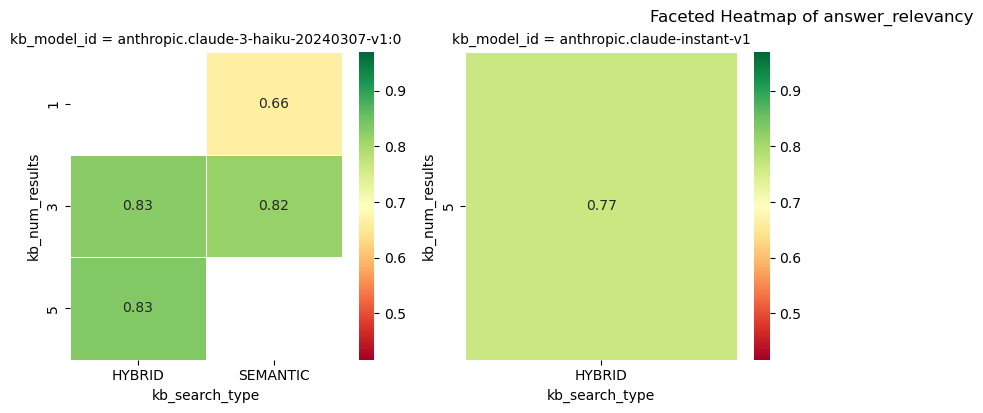

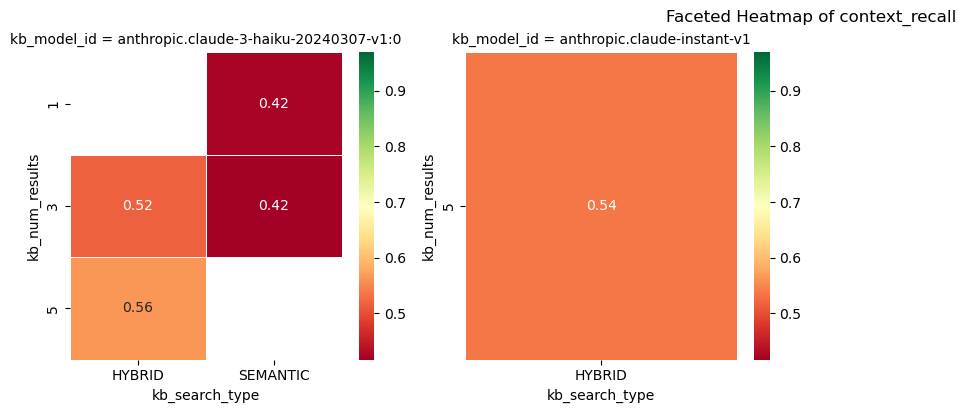

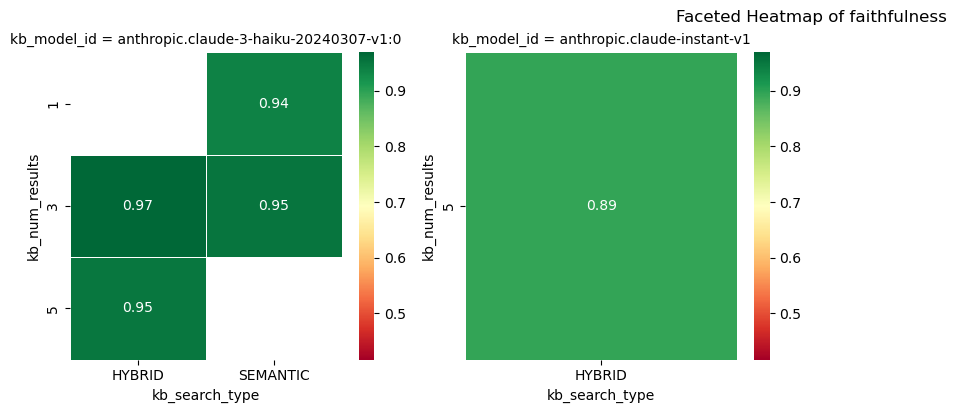

In [17]:
import os
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product

def find_yaml_files(directory):
    """Recursively find all YAML files in the directory."""
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.yml'):
                yield os.path.join(root, file)

def parse_yaml_file(file_path):
    """Parse the YAML file and extract relevant data."""
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
        return data

def create_experiment_matrix(directory):
    results = defaultdict(list)
    
    # Find and parse all YAML files
    for yaml_file in find_yaml_files(directory):
        data = parse_yaml_file(yaml_file)
        # Collect all `kb_` parameters
        params = {k: v for k, v in data.items() if k.startswith('kb_') and k != 'kb_id'}
        key = tuple(sorted(params.items()))
        results[key].append({
            'answer_relevancy': float(data['answer_relevancy']),
            'context_recall': float(data['context_recall']),
            'faithfulness': float(data['faithfulness'])
        })

    # Aggregate and prepare DataFrame
    rows = []
    for param_combo, metrics_list in results.items():
        avg_metrics = {metric: np.mean([m[metric] for m in metrics_list]) for metric in ['answer_relevancy', 'context_recall', 'faithfulness']}
        row = dict(param_combo)
        row.update(avg_metrics)
        rows.append(row)
    
    return pd.DataFrame(rows)

def plot_faceted_heatmaps(df, facet_by, index_param, column_param):
    if df.empty:
        print("No data to display.")
        return

    metrics = ['answer_relevancy', 'context_recall', 'faithfulness']
    facet_values = df[facet_by].unique()
    
    # Determine the global min and max values for the color scale
    vmin = df[metrics].min().min()
    vmax = df[metrics].max().max()

    for metric in metrics:
        g = sns.FacetGrid(df, col=facet_by, col_wrap=4, height=4, sharex=False, sharey=False)
        g.map_dataframe(draw_heatmap, index=index_param, columns=column_param, values=metric, vmin=vmin, vmax=vmax, cmap='RdYlGn')
        g.fig.suptitle(f'Faceted Heatmap of {metric}', y=1.02)
        plt.show()

def draw_heatmap(data, index, columns, values, vmin, vmax, cmap, **kwargs):
    pivoted_data = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean')
    sns.heatmap(pivoted_data, annot=True, fmt=".2f", vmin=vmin, vmax=vmax, cmap=cmap, linewidths=.5)

# Usage
directory = '.'  # Set the directory to search for YAML files
experiment_matrix = create_experiment_matrix(directory)
if not experiment_matrix.empty:
    # Define which parameters to facet by, and which to use as indices and columns in heatmaps
    plot_faceted_heatmaps(experiment_matrix, 'kb_model_id', 'kb_num_results', 'kb_search_type')
else:
    print("No data available.")
